In [1]:
from collections import OrderedDict
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
from itertools import product

In [2]:
log_root = '../logs/'

In [3]:
data = 'cifar10'

exp_names = {
    f'{data}/Adam/alexgda_gamma0.0_delta1.0_G0.0001_D0.0001': 'Sim-Adam\n(G1e-4,D1e-4)',
    f'{data}/Adam/altgda_gamma1.0_delta1.0_G0.0003_D0.0003': 'Alt-Adam\n(G3e-4,D3e-4)',
    f'{data}/Adam/alexgda_gamma1.0_delta1.2_G0.0003_D0.0003': 'Alex-Adam\n($\gamma=1,\delta=1.2$)\n(G3e-4,D3e-4)',
}

In [4]:
# lrG = 0.0001
# lrD = 0.0003
# data = 'cifar10'

# exp_names = {
#     f'{data}/Adam/simgda_gamma0.0_delta1.0_G{lrG}_D{lrD}': 'Sim-GDA',
#     f'{data}/Adam/altgda_gamma1.0_delta1.0_G{lrG}_D{lrD}': 'Alt-GDA',
# }

# for gamma, delta in product([1, 0, 1.1, 1.2, 1.3, 1.4, 1.5, 2], [1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2]):
#     exp_names[
#         f'{data}/Adam/alexgda_gamma{float(gamma)}_delta{float(delta)}_G{lrG}_D{lrD}'
#     ] = f'Alex-GDA($\gamma={gamma},\delta={delta}$)'

In [5]:
scores_dict = {dir: [] for dir in exp_names}
for dir in exp_names:
    for i, path in enumerate(sorted(glob(os.path.join(log_root, dir, '*')))):
        filename = os.path.join(path, 'FID.json')
        if not os.path.exists(filename): continue
        with open(filename) as f:
            scores_list = json.load(f)
        scores_dict[dir].append(scores_list[-1])
scores_dict = OrderedDict(reversed([(dir, np.array(sorted(scores_list))) for dir, scores_list in scores_dict.items() if len(scores_list)>0]))
scores_dict

OrderedDict([('cifar10/Adam/alexgda_gamma1.0_delta1.2_G0.0003_D0.0003',
              array([21.87195664, 22.09942521, 24.33361516, 25.25014797, 25.41578393])),
             ('cifar10/Adam/altgda_gamma1.0_delta1.0_G0.0003_D0.0003',
              array([20.44368391, 23.00097273, 23.20988145, 23.48823785, 24.2025106 ,
                     24.6094737 , 24.90673249, 25.47318573, 25.97744999, 26.50956772])),
             ('cifar10/Adam/alexgda_gamma0.0_delta1.0_G0.0001_D0.0001',
              array([43.44296784, 43.9228243 , 44.62755272, 46.05638558, 46.72066003]))])

In [6]:
# scores_means = [scipy.stats.trim_mean(scores, .25) for scores in scores_dict.values()]
scores_means = [np.mean(scores) for scores in scores_dict.values()]
scores_stds = [np.std(scores) for scores in scores_dict.values()]
scores_errs = np.array([[mean-np.min(scores),np.max(scores)-mean] for scores, mean in zip(scores_dict.values(), scores_means)]).T
names = [exp_names[k] for k in scores_dict]
# scores_means, scores_errs

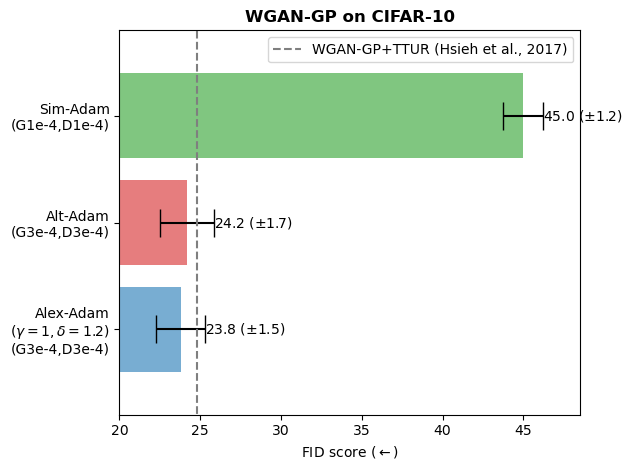

In [7]:
fig, axes = plt.subplots(1,1)
ax = axes
# bar = ax.barh(names, scores_means, xerr=scores_stds, capsize=10, alpha=0.6, color=[c['color'] for c in plt.cycler(color=plt.cm.tab10.colors)])
bar = ax.barh(names, scores_means, xerr=scores_stds, capsize=10, alpha=0.6, color=['tab:blue', 'tab:red', 'tab:green'])
means = map(lambda x: round(x,1), scores_means)
stds = map(lambda x: round(x,1), scores_stds)
ax.bar_label(bar, map(lambda x: f"{x[0]} ($\pm${x[1]})", zip(means, stds)))
ax.set_xlim(left=20)
ax.set_xlabel('FID score ($\leftarrow$)')
ax.set_title('WGAN-GP on CIFAR-10', weight='bold')
ax.vlines(24.8, -1, len(names), linestyles='--', color='tab:gray', label="WGAN-GP+TTUR (Hsieh et al., 2017)")
ax.set_ylim(-.8, len(names)-.2)
ax.legend()
fig.tight_layout()
fig.savefig('vis_cifar10.pdf')

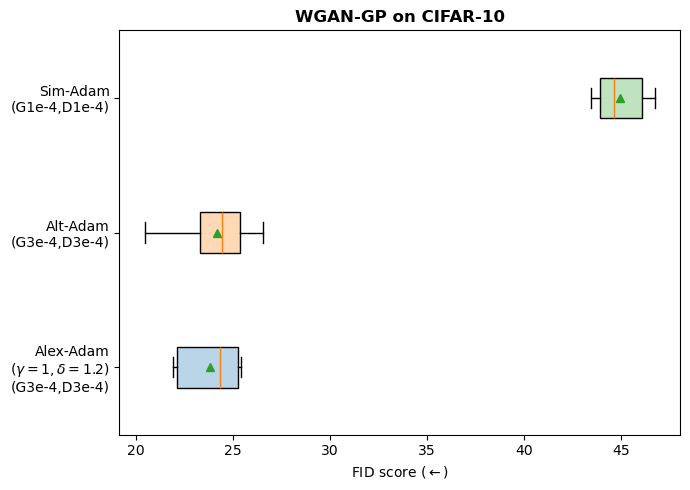

In [8]:
fig, axes = plt.subplots(1,1, figsize=(7,5))
ax = axes
bp = ax.boxplot(scores_dict.values(), vert=False, labels=names, showmeans=True,  patch_artist=True)
for patch, color in zip(bp['boxes'], [c['color'] for c in plt.cycler(color=plt.cm.tab10.colors)]*10):
    patch.set_facecolor(color + (0.3,))
ax.set_xlabel('FID score ($\leftarrow$)')
ax.set_title("WGAN-GP on CIFAR-10", weight='bold')
fig.tight_layout()
fig.savefig('vis_cifar10_2.pdf')